In [1]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, CSV file I/O
from glob import glob           # matches dir with example 
from skimage.io import imread   # read image from library 
import os                       # portable way of using os dependent functions and to manupulate path
import shutil                   # offers high level operations on files like copying and removal 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator   # image generation after data augmentation constructor
                                                            # network with weights pre-trained on Image net
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception           # network with weights pre-trained on Image net
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D   # to prevent over-fitting
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint     # to get a view on internal states and statistics of the model during training
from keras.optimizers import Adam                          # reduces the loss 
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


In [5]:
!pip install scikit-image


     |████████████████████████████████| 26.3MB 235kB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 166kB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 156kB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 422kB/s eta 0:00:01
     |████████████████████████████████| 3.3MB 540kB/s eta 0:00:01
  Stored in directory: /home/supermicro/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx


In [2]:
# Output files

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "model_plot.png"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

In [3]:
#Hyper Parameter

SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.75
IMAGE_SIZE = 96
EPOCHS = 10           # forward and backward pass for all the training examples
BATCH_SIZE = 16    # no. of training example in 1 forward/backward pass
VERBOSITY = 1         # dict. training parameter
TESTING_BATCH_SIZE = 5000   #mini-batch

In [7]:
# Data 
#input_dir

input_dir = (r"/home/supermicro/Desktop/KulGarima/histopathologic-cancer-detection/")
training_dir = input_dir + 'train/'

data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})       # *tif image format for high level graphics

#print("1Now df is: ",data_frame)

data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[7].split('.')[0])     # lamba fun. to split the info to get it into the data frame ring credit
print("1Now df is: ",data_frame)

labels = pd.read_csv(input_dir + 'train_labels.csv')
# print(labels)
data_frame = data_frame.merge(labels, on='id')

# print("2Now df is: ",data_frame)


negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT) if len(data_frame) > 0 else data_frame    # labels are encoded as code cannot undestand categorised data

positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT) if len(data_frame) > 0 else data_frame

# print("3Now df is: ",data_frame)

data_frame = pd.concat([negatives, positives]).reset_index() 
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

# print("4Now df is: ",data_frame)

training_path = (r"/home/supermicro/Desktop/KulGarima/histopathologic-cancer-detection/training")
validation_path = (r"/home/supermicro/Desktop/KulGarima/histopathologic-cancer-detection/validation")

for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])
# stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter. 

data_frame.set_index('id', inplace=True)

for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        
        if not os.path.exists(destination):
            source = os.path.join(input_dir + 'train', file_name)
            shutil.copyfile(source, destination)
            
             


1Now df is:                                                       path  \
0       /home/supermicro/Desktop/KulGarima/histopathol...   
1       /home/supermicro/Desktop/KulGarima/histopathol...   
2       /home/supermicro/Desktop/KulGarima/histopathol...   
3       /home/supermicro/Desktop/KulGarima/histopathol...   
4       /home/supermicro/Desktop/KulGarima/histopathol...   
5       /home/supermicro/Desktop/KulGarima/histopathol...   
6       /home/supermicro/Desktop/KulGarima/histopathol...   
7       /home/supermicro/Desktop/KulGarima/histopathol...   
8       /home/supermicro/Desktop/KulGarima/histopathol...   
9       /home/supermicro/Desktop/KulGarima/histopathol...   
10      /home/supermicro/Desktop/KulGarima/histopathol...   
11      /home/supermicro/Desktop/KulGarima/histopathol...   
12      /home/supermicro/Desktop/KulGarima/histopathol...   
13      /home/supermicro/Desktop/KulGarima/histopathol...   
14      /home/supermicro/Desktop/KulGarima/histopathol...   
15      /ho

In [8]:
# Data augmentation : 
# used to expand the training dataset in order to improve the performance and ability of the model to generalize.

training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [9]:
# Data generation:
# above constructor is implemented here to generate new datasets
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)

training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')

testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)


Found 178370 images belonging to 2 classes.
Found 76506 images belonging to 2 classes.
Found 76506 images belonging to 2 classes.


In [11]:
# Model

# As starting layer of CNN is only about its shape and structure nothing is data specific therefore olderly trained models are used as starting layer and other layers are taken accordingly 

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

xception = Xception(include_top=False, input_shape=input_shape)(inputs)       # starting layer of this pre-trained model is used as input
resnet50 = ResNet50(include_top=False, input_shape=input_shape)(inputs)

# As CNN is only an used for image analysis, for classification purpose it is passed through the normal neural network. NN does not take matrix form of input 

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(resnet50)])    # output of CNN which was in matrix from is changed into vector form and both model are concat.
outputs = Dropout(0.5)(outputs)                     # It will train on the probability of 50%
outputs = Dense(1, activation='sigmoid')(outputs)   # probability is given by last layer in sigmoid func.


# Adam is computationally efficient, has little memory requirements, and is well suited for problems that are large in terms of data and/or parameters
# Adam maintains a pre-parameter lerning rate that can be adapted and improved with gradient unlike SGD

model = Model(inputs, outputs)                            # model compilation
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),   # reduces the loss
              loss='binary_crossentropy',                 # as a loss func. for error calculation
              metrics=['accuracy'])
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 3, 3, 2048)   20861480    input_4[0][0]                    
__________________________________________________________________________________________________
resnet50 (Model)                (None, 3, 3, 2048)   23587712    input_4[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           xception[1][0]              

In [ ]:
plot_model(model,
          to_file = MODEL_PLOT_FILE,
          show_shapes = True
          show_layer_names = True)


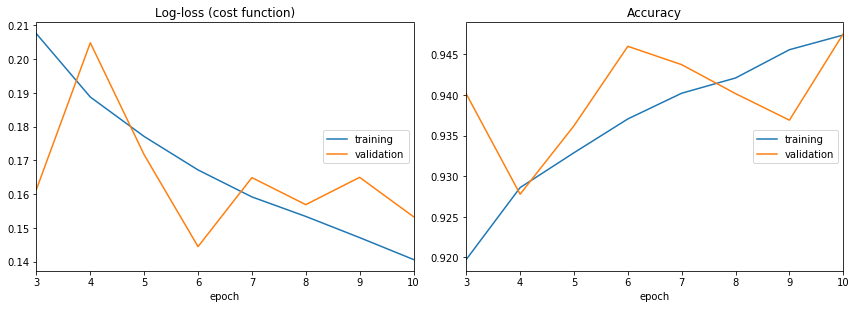

Log-loss (cost function):
training   (min:    0.141, max:    0.307, cur:    0.141)
validation (min:    0.144, max:    0.217, cur:    0.153)

Accuracy:
training   (min:    0.873, max:    0.947, cur:    0.947)
validation (min:    0.919, max:    0.948, cur:    0.948)

Epoch 00010: val_acc improved from 0.94600 to 0.94755, saving model to model.h5


In [12]:
#  Training

history = model.fit_generator(generator=training_generator,                    # as data is augmentaed model.fit_generator is used otherwise model.fit only
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                                         
                              # to get a view on internal states and statistics of the model during training
                              
                              callbacks=[PlotLossesCallback(),
                                 ModelCheckpoint(MODEL_FILE,                # saves the model after every epoch 
                                                         monitor='val_acc',  # quantity to monitor.
                                                         verbose=VERBOSITY,
                                                         save_best_only=True, # the latest best model according to the quantity monitored will not be overwritten.
                                                         mode='max'),
                                         
                                 CSVLogger(TRAINING_LOGS_FILE,        # used as debugger while callbacking  
                                                                  # Callback that streams epoch results to a csv file
                                       append=False,              # False so overwrite the existing file
                                       separator=',')])           # string used to separate elements in the csv file.


In [14]:
# Kaggle testing

testing_files = glob(os.path.join(r"/home/supermicro/Desktop/KulGarima/histopathologic-cancer-detection/test/",'*.tif'))
submission = pd.DataFrame()

for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[7].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]      # 255.0 is used to normalise the value between 0 & 1
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    
submission.to_csv(KAGGLE_SUBMISSION_FILE, index=False, header=True)

In [19]:
pd.read_csv("kaggle_submission.csv")
print(data_frame)

                                                   path  \
0     /home/supermicro/Desktop/KulGarima/histopathol...   
1     /home/supermicro/Desktop/KulGarima/histopathol...   
2     /home/supermicro/Desktop/KulGarima/histopathol...   
3     /home/supermicro/Desktop/KulGarima/histopathol...   
4     /home/supermicro/Desktop/KulGarima/histopathol...   
5     /home/supermicro/Desktop/KulGarima/histopathol...   
6     /home/supermicro/Desktop/KulGarima/histopathol...   
7     /home/supermicro/Desktop/KulGarima/histopathol...   
8     /home/supermicro/Desktop/KulGarima/histopathol...   
9     /home/supermicro/Desktop/KulGarima/histopathol...   
10    /home/supermicro/Desktop/KulGarima/histopathol...   
11    /home/supermicro/Desktop/KulGarima/histopathol...   
12    /home/supermicro/Desktop/KulGarima/histopathol...   
13    /home/supermicro/Desktop/KulGarima/histopathol...   
14    /home/supermicro/Desktop/KulGarima/histopathol...   
15    /home/supermicro/Desktop/KulGarima/histopathol... 